In [233]:
# reload all module before executing code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cleaning the Weekly Rental Data

In [234]:
import pandas as pd
import os, re

In [235]:
pd.set_option("display.max_rows", None)  # Show all rows, default is 10
pd.set_option("display.max_columns", None)  # Show all columns, default is 20

## Download Data

### Scraped Domain Data

In [236]:
# set download path
data_path = "../data/raw/domain/"

# list csv files, make sure they match
csv_files = [file for file in os.listdir(data_path) if re.match(r'rental_listings_\d{4}_\d{2}.csv', file)]

In [237]:
# list of dataframes 
df_list = []

# read each file, extract year and month from filename, add as columns
for file in csv_files:
    match = re.search(r'rental_listings_(\d{4})_(\d{2}).csv', file)
    if match:
        year = match.group(1)
        quarter = match.group(2)
        df = pd.read_csv(os.path.join(data_path, file))
        df['year'] = year
        df['quarter'] = quarter
        df_list.append(df)

# concatenate all dataframes
df = pd.concat(df_list, ignore_index=True)

In [238]:
print(df.iloc[-1])

property_id                                                   17537987.0
url                           /5-40-sandwych-wentworth-nsw-2648-17537987
rental_price                                               $320 per week
bedrooms                                                             2.0
bathrooms                                                            1.0
car_spaces                                                           1.0
property_type                                    Apartment / Unit / Flat
land_area                                                            0.0
property_features                                             2, ,1, ,1,
suburb                                                         WENTWORTH
postcode                                                            2648
scraped_date                                         2025-04-25 21:10:55
wayback_url            https://web.archive.org/web/20250425211055/htt...
wayback_time                                       

In [239]:
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Rows: 31268, Columns: 52


In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31268 entries, 0 to 31267
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          31265 non-null  float64
 1   url                  31268 non-null  object 
 2   rental_price         31265 non-null  object 
 3   bedrooms             30944 non-null  object 
 4   bathrooms            17067 non-null  float64
 5   car_spaces           29156 non-null  float64
 6   property_type        31265 non-null  object 
 7   land_area            17122 non-null  float64
 8   property_features    31240 non-null  object 
 9   suburb               31268 non-null  object 
 10  postcode             31268 non-null  int64  
 11  scraped_date         17122 non-null  object 
 12  wayback_url          17122 non-null  object 
 13  wayback_time         17122 non-null  float64
 14  year                 31268 non-null  object 
 15  quarter              31268 non-null 

### Suburb CSV

In [241]:
# import the suburb csv as a new dataframe
suburb_df = pd.read_csv("../data/geo/vic_suburbs_postcodes.csv")

In [242]:
# lowercase suburb names for both dataframes to ensure consistency
suburb_df['suburb'] = suburb_df['suburb'].str.lower()
df['suburb'] = df['suburb'].str.lower()

In [243]:
print(f"Rows: {suburb_df.shape[0]}, Columns: {suburb_df.shape[1]}")

Rows: 3186, Columns: 2


In [244]:
df['suburb'].nunique(), df['postcode'].nunique()

(1031, 512)

We clearly have to check the suburbs for duplicates, typos, and possible records outside of Victoria

# Column Standardisation

Let's begin by standardising the columns

This will include: 

- checking for inconsistent column names across files
- rename columns to snake_case
- drop irrelevant columns

In [245]:
# standardise column names to snake_case
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31268 entries, 0 to 31267
Data columns (total 52 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          31265 non-null  float64
 1   url                  31268 non-null  object 
 2   rental_price         31265 non-null  object 
 3   bedrooms             30944 non-null  object 
 4   bathrooms            17067 non-null  float64
 5   car_spaces           29156 non-null  float64
 6   property_type        31265 non-null  object 
 7   land_area            17122 non-null  float64
 8   property_features    31240 non-null  object 
 9   suburb               31268 non-null  object 
 10  postcode             31268 non-null  int64  
 11  scraped_date         17122 non-null  object 
 12  wayback_url          17122 non-null  object 
 13  wayback_time         17122 non-null  float64
 14  year                 31268 non-null  object 
 15  quarter              31268 non-null 

In [247]:
# only keep relevant columns
relevant_columns = [
    'property_id','rental_price', 'bedrooms', 'bathrooms', 'car_spaces',
    'property_type', 'land_area', 'property_features', 
    'suburb', 'postcode', 'year', 'quarter',
    'age_0_to_19', 'age_20_to_39', 'age_40_to_59', 'age_60_plus',
    'agency_name', 'agent_name', 'appointment_only', 'avg_days_on_market',
    'description', 'family_percentage', 'features_list', 
    'first_listed_date', 'full_address', 'last_sold_date',
    'latitude', 'longitude', 'listing_status', 'long_term_resident', 
    'median_rent_price', 'median_sold_price', 'number_sold',
    'renter_percentage', 'schools', 'single_percentage',
    'state_abbreviation', 'structured_features', 'unit_number', 'updated_date',
    'url'
]

df = df[relevant_columns]

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31268 entries, 0 to 31267
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          31265 non-null  float64
 1   rental_price         31265 non-null  object 
 2   bedrooms             30944 non-null  object 
 3   bathrooms            17067 non-null  float64
 4   car_spaces           29156 non-null  float64
 5   property_type        31265 non-null  object 
 6   land_area            17122 non-null  float64
 7   property_features    31240 non-null  object 
 8   suburb               31268 non-null  object 
 9   postcode             31268 non-null  int64  
 10  year                 31268 non-null  object 
 11  quarter              31268 non-null  object 
 12  age_0_to_19          14143 non-null  float64
 13  age_20_to_39         14143 non-null  float64
 14  age_40_to_59         14143 non-null  float64
 15  age_60_plus          14143 non-null 

In [249]:
df['state_abbreviation'].value_counts()

state_abbreviation
vic    14143
Name: count, dtype: int64

## Record Standardisation
Let's standardise our data in the following ways:
- stripping leading/trailing spaces
- lowercasing
- collapse multiple spaces
- remove punctuation 
- standardise abbreviations
- validate against controlled vocabularies


In [250]:
# create a udf to preprocess string columns
def preprocess_string_column(col):
    """
    Preprocess a string column by:
    - stripping leading/trailing spaces
    - collapsing multiple spaces
    - removing punctuation (except for hyphens and apostrophes)
    - lowercasing
    """
    if pd.isna(col):
        return col
    # handle non-string entries
    if not isinstance(col, str):
        col = str(col)
    # strip leading/trailing spaces
    col = col.strip()
    # collapse multiple spaces
    col = re.sub(r'\s+', ' ', col)
    # remove punctuation (except for hyphens and apostrophes)
    col = re.sub(r'[^\w\s\'-]', '', col)
    # lowercase
    col = col.lower()
    return col

In [251]:
# apply string preprocessing to columns with type object
string_columns = df.select_dtypes(include=['object']).columns.tolist()
# we need the formatting in 'property_features' for some features
string_columns.remove('property_features')  # exclude 'property_features'
for col in string_columns:
    df[col] = df[col].apply(preprocess_string_column)
    # run twice in case of special situations
    df[col] = df[col].apply(preprocess_string_column)

### Suburbs

In [252]:
df['suburb'].nunique(), df['postcode'].nunique()

(1031, 512)

In [253]:
df['suburb'].sort_values().unique()

array(['abbotsford', 'aberfeldie', 'acheron', ..., 'yellingbo', 'yendon',
       'yinnar south'], shape=(1031,), dtype=object)

In [254]:
suburb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3186 entries, 0 to 3185
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   postcode  3186 non-null   int64 
 1   suburb    3186 non-null   object
dtypes: int64(1), object(1)
memory usage: 49.9+ KB


In [255]:
# which entries from suburb_df['suburb'] are not in df['suburb']
suburb_df[~suburb_df['suburb'].isin(df['suburb'])].count()

postcode    2129
suburb      2129
dtype: int64

## Dealing with Missing Values

Let's first inspect the missing values to see if there are any trends

In [256]:
df.isna().sum()

property_id                3
rental_price               3
bedrooms                 324
bathrooms              14201
car_spaces              2112
property_type              3
land_area              14146
property_features         28
suburb                     0
postcode                   0
year                       0
quarter                    0
age_0_to_19            17125
age_20_to_39           17125
age_40_to_59           17125
age_60_plus            17125
agency_name            17125
agent_name             17396
appointment_only       17516
avg_days_on_market     17126
description            17127
family_percentage      17125
features_list          23274
first_listed_date      17125
full_address           17125
last_sold_date         28958
latitude               17125
longitude              17125
listing_status         17125
long_term_resident     17125
median_rent_price      17126
median_sold_price      17126
number_sold            17125
renter_percentage      17125
schools       

First of all, having rental_price is essential; drop the records without this value

In [257]:
# drop rows where rental_price is missing
df = df.dropna(subset=['rental_price'])

In [258]:
df.shape

(31265, 41)

In [259]:
df['property_id'].nunique()

29333

We see that there are duplicate listing records for the same property. We remove these duplicates by picking the listing with the most recent (year, quarter).

In [260]:
# sort df by (year, quarter) descending
df = df.sort_values(by=['year', 'quarter'], ascending=False)
# drop duplicates
df = df.drop_duplicates(subset=['property_id'])
df.shape

(29333, 41)

In [261]:
# Convert the columns latitude and longitude to a Point (only if latitude and longitude are not null), call the column coordinates 
# drop latitude and longitude columns
from shapely.geometry import Point

df['coordinates'] = df[['latitude', 'longitude']].apply(lambda x: Point(x['latitude'], x['longitude']) if not pd.isna(x['latitude']) and not pd.isna(x['longitude']) else None, axis=1)
df = df.drop(columns=['latitude', 'longitude'])

In [262]:
# Import the GeoUtils class from utils/geo.py
from utils.geo import GeoUtils

# Initialize GeoUtils 
geoutils = GeoUtils()

# create a mask where full address is null 
mask = df['full_address'].isna()

# extracting full address from url for the wayback listings
df.loc[mask, 'full_address'] = df.loc[mask, 'url'].apply(geoutils.extract_address_from_url)


ModuleNotFoundError: No module named 'utils.geo'

The geocoding API takes a very long time to run, so the results have been saved to `data/processed/domain/rental_listings_summary_cleaned.csv`. We load in the results here. 

In [263]:
df_tmp = pd.read_csv('../data/processed/domain/rental_listings_summary_cleaned.csv')

mask = df['coordinates'].isna()
coordinate_mapping = df_tmp.set_index('property_id')['coordinates'].to_dict()
df.loc[mask, 'coordinates'] = df.loc[mask, 'property_id'].map(coordinate_mapping)


In [264]:
df['coordinates'].isna().sum()


np.int64(3856)

We see that there are still listings without coordinates because the Nominatim API could not get a result. We'll save these listings into `data/raw/rental_listings_missing_coordinates.csv` for further processing with another API (OpenRouteService). Because we are limited by only 500 requests per API key per day, we have to impute these missing coordinates intermitently. 

In [265]:
# save the listings without coordinates
# use os to make the directory if it doesn't exist
os.makedirs('../data/raw/missing_geo/', exist_ok=True)
df[df['coordinates'].isna()].to_csv('../data/raw/missing_geo/rental_listings_missing_coordinates.csv', index=False)


In [266]:
# save intermediate df result 
saved_df = df.copy()

In [267]:
saved_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29333 entries, 10077 to 24952
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_id          29333 non-null  float64
 1   rental_price         29333 non-null  object 
 2   bedrooms             29057 non-null  object 
 3   bathrooms            15178 non-null  float64
 4   car_spaces           27530 non-null  float64
 5   property_type        29333 non-null  object 
 6   land_area            15190 non-null  float64
 7   property_features    29305 non-null  object 
 8   suburb               29333 non-null  object 
 9   postcode             29333 non-null  int64  
 10  year                 29333 non-null  object 
 11  quarter              29333 non-null  object 
 12  age_0_to_19          14143 non-null  float64
 13  age_20_to_39         14143 non-null  float64
 14  age_40_to_59         14143 non-null  float64
 15  age_60_plus          14143 non-null  

### Clean and Convert Key Fields

We need to clean and convert columns to be more standardised and easier to analyse

Let's start with the rental_price.



First, let's remove '$' and ',' from the values

In [268]:
# remove '$' and ',' from rental_price 
df['rental_price'] = df['rental_price'].replace('[\$,]', '', regex=True).astype(str)

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
/tmp/ipykernel_49780/641504744.py:2: SyntaxWarning: invalid escape sequence '\$'
  df['rental_price'] = df['rental_price'].replace('[\$,]', '', regex=True).astype(str)


Convert to lower casing to remove some duplicates

In [269]:
df["rental_price"] = df["rental_price"].str.lower()

There are a number of values in which we do not want

In [270]:
# remove spaces in rental_price
df['rental_price'] = df['rental_price'].str.replace(' ', '')

In [271]:
# keep records which start with a number
df = df[df['rental_price'].str.match(r'^\d')]

In [272]:
print(df['rental_price'].value_counts().sort_values())

rental_price
290pw-savetimeviewour3dtourapply                1
140000perweek                                   1
480perweekavailablenow                          1
1700weekly                                      1
102000                                          1
88500                                           1
1295                                            1
480perweek-2086percalendarmonth                 1
670perweekinclutilities                         1
360perweek-unfurnished                          1
696perweek                                      1
335weekly                                       1
50                                              1
525perweekpw                                    1
870pw                                           1
420pw-savetimeviewour3dtourapply                1
450w                                            1
30wk                                            1
27perweek                                       1
22perweek                            

In [273]:
# extract numeric value from rental_price (based on the first number found)
df['price_value'] = df["rental_price"].str.extract(r"(\d+(?:\.\d+)?)").astype(float)

We also need a column to see if the rent is by weekly or monthly payments

In [274]:
freq_keywords = [
    'pw', 'perweek', 'weekly', 'p/w', 'wk', 'p.w.',
    '/wk', '/w', '/week', 'p.w',
    'permonth', 'pm', 'calendar', 'monthly', 'calender',
    'percalendarmonth', 'percalendermonth'
    ]

In [275]:
# Extract frequency keyword after the number
df["price_frequency"] = df["rental_price"].str.extract(r"(\d+(?:\.\d+)?)+(" + "|".join(freq_keywords) + ")", expand=False)[1]

In [276]:
# Map known patterns to standardized categories
df["price_frequency"] = df["price_frequency"].map({
    "pw": "weekly",
    "p.w.": "weekly",
    "perweek": "weekly",
    "weekly": "weekly",
    "p/w": "weekly",
    "wk": "weekly",
    "p.w": "weekly",
    "/wk": "weekly",
    "/w": "weekly",
    "/week": "weekly",
    "pm": "monthly",
    "permonth": "monthly",
    "calendar": "monthly",
    "calender": "monthly",
    "monthly": "monthly",
    "percalendarmonth": "monthly",
    "percalendermonth": "monthly"
})

In [277]:
# If price is purely numeric (digits and full stops), assume weekly
numeric_mask = df["rental_price"].str.match(r"^[\d\.]+$")
df.loc[numeric_mask & df["price_frequency"].isna(), "price_frequency"] = "weekly"

# Assign 'unknown' to unmatched entries
df["price_frequency"] = df["price_frequency"].fillna("unknown")

# Convert to categorical type
df["price_frequency"] = pd.Categorical(df["price_frequency"], categories=["weekly", "monthly", "unknown"])

In [278]:
df['price_frequency'].value_counts()

price_frequency
weekly     28766
unknown       87
monthly       66
Name: count, dtype: int64

In [279]:
df[df['price_frequency'] == 'unknown']['rental_price'].value_counts().sort_values()

rental_price
25000paavailablenow                    1
950week                                1
250month                               1
850week                                1
75wcarpark                             1
650tojuly2025                          1
250wallbillsincludedinrent             1
1380week                               1
325weekac1412pcm                       1
39000paoutgoings                       1
52000perannumplusgst                   1
720incbillsperweek                     1
750week                                1
170to240                               1
1400week                               1
570-fullyfurnished                     1
900includesbillsperweek                1
2384percalandarmonth                   1
520-perweek-fullyfurnished             1
340weekfullyfurnished                  1
809to889                               1
680andfullyfurnishedoptionatextrapw    1
600onhold                              1
1950pcmincludinggst                    1
950

In [280]:
# drop unknown price_frequency
df = df[df['price_frequency'] != 'unknown']

Now that we have a column for the actual price and a column for frequency, let's now calculate the weekly price and replace the rental price with that

In [281]:
# Create weekly_rent based on price_frequency
df["weekly_rent"] = df.apply(
    lambda row: row["price_value"] if row["price_frequency"] == "weekly"
    else row["price_value"] / 4 if row["price_frequency"] == "monthly"
    else None,
    axis=1
)

# Drop original columns
df = df.drop(columns=["rental_price", "price_value", "price_frequency"])


In [282]:
df["weekly_rent"].describe()

count    2.883200e+04
mean     6.924642e+03
std      5.663043e+04
min      1.800000e+01
25%      4.700000e+02
50%      5.700000e+02
75%      7.300000e+02
max      5.302303e+06
Name: weekly_rent, dtype: float64

Let's first deal with the outliers using IQR

In [283]:
import numpy as np
import math as m

# Removing the outliers
def removeOutliers(dataframe, columns):
    """
    Detects and treats outliers using IQR for multiple variables in a DataFrame.
    :param dataframe: The input DataFrame
    :param columns: A list of columns to apply IQR outlier treatment
    :param n: number of records in the dataframe
    :param factor: The IQR factor to use for detecting outliers
    :return: The processed DataFrame with outliers treated
    """

    # calculate the factor based on the number of records
    factor = m.sqrt(np.log(len(dataframe))) - 0.5

    # iterate through each column to treat outliers
    for col in columns:
        # calculate Q1, Q3, and IQR
        Q3 = np.quantile(dataframe[col], 0.75)
        Q1 = np.quantile(dataframe[col], 0.25)
        IQR = Q3 - Q1

        print("IQR value for column %s is: %s" % (col, IQR))

        # determine the lower and upper range for outliers
        lower_range = Q1 - factor * IQR
        upper_range = Q3 + factor * IQR
        
        # filter dataframe to keep only rows within the IQR range
        dataframe = dataframe[(dataframe[col] >= lower_range) & (dataframe[col] <= upper_range)]
        print("After treating outliers, shape of data is: ", dataframe.shape)
    
    return dataframe

In [284]:
df = removeOutliers(df, ['weekly_rent'])

IQR value for column weekly_rent is: 260.0
After treating outliers, shape of data is:  (25714, 40)


Text(0.5, 1.0, 'Distribution of Weekly Rent Prices')

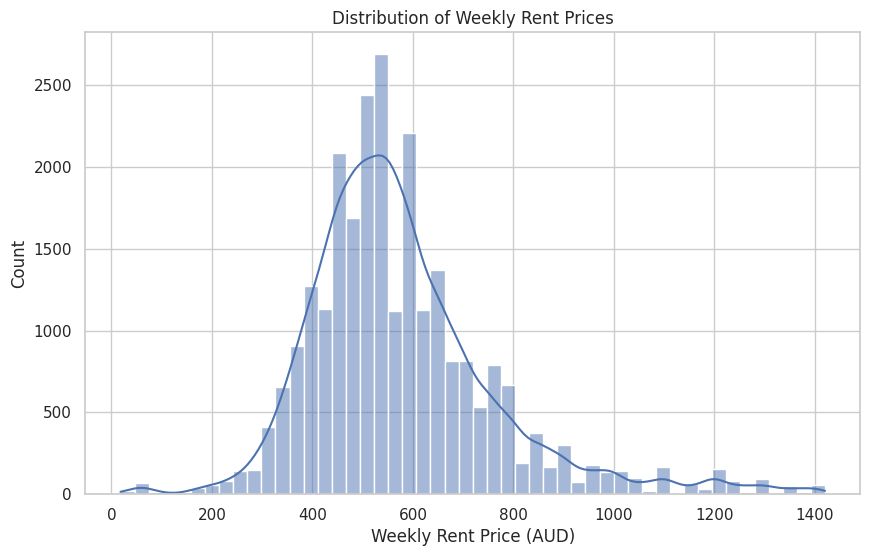

In [285]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(df["weekly_rent"], bins=50, kde=True)

# Add labels and title
plt.xlabel("Weekly Rent Price (AUD)")
plt.ylabel("Count")
plt.title("Distribution of Weekly Rent Prices")

In [286]:
# save intermediate df result
saved_df = df.copy()

In [287]:
saved_df.shape

(25714, 40)

## Cleaning Property Features

In order to answer question 2: Forecasting Rent Growth for suburbs, we need to match our scraped data's categories with provided ones from the ABS website.

The ABS dataset is aggregated by number of bedrooms and property type(1-3 for flats and 1-4 for houses), as well as a separate sheet for the grand total median over suburbs.

We will match that formatting with our scraped data by creating a new dataframe with each suburb as a record, and type of property + number of bedrooms for its columns. Each entry will be the median price of that combination.

### Number of Bedrooms

In [288]:
# find records where 'bedrooms' is missing and 'property_features' doesn't have digits
missing_bedrooms_features = df[df['bedrooms'].isnull() & ~df['property_features'].str.contains('\d', na=False)]

# drop rows where bedrooms is missing and 'property_features' doesn't have digits
df = df.drop(missing_bedrooms_features.index)

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_49780/3890117457.py:2: SyntaxWarning: invalid escape sequence '\d'
  missing_bedrooms_features = df[df['bedrooms'].isnull() & ~df['property_features'].str.contains('\d', na=False)]


In [289]:
# drop rows where property_features that do not start with a digit and bedrooms is missing
df_no_digit = df[df['property_features'].str.match(r'^\D', na=False)]
df_no_digit = df_no_digit[df_no_digit['bedrooms'].isnull()]
df = df.drop(df_no_digit.index)

In [290]:
# see if 'bedrooms' matches the first number in 'property_features'
bedroom_pattern = r'(?<!\,)(\d),'
df['extracted_bedrooms'] = df['property_features'].str.extract(bedroom_pattern, flags=re.IGNORECASE)[0].astype(float)

# remove records where 'bedrooms' is missing and 'extracted_bedrooms' is also missing
df = df[~(df['bedrooms'].isnull() & df['extracted_bedrooms'].isnull())]

In [291]:
df.head()

property_id bedrooms  bathrooms  car_spaces        property_type  \
10077   17732837.0        3        NaN         2.0            townhouse   
10078   17744154.0        2        NaN         2.0  apartment unit flat   
10079   17750349.0        1        NaN         1.0  apartment unit flat   
10080   17739910.0        2        NaN         1.0            townhouse   
10081   17751219.0        2        NaN         1.0                house   

       land_area property_features      suburb  postcode  year quarter  \
10077        NaN        3, ,2, ,2,  abbotsford      3067  2025      09   
10078        NaN        2, ,2, ,1,  abbotsford      3067  2025      09   
10079        NaN        1, ,1, ,1,  abbotsford      3067  2025      09   
10080        NaN        2, ,1, ,1,  abbotsford      3067  2025      09   
10081        NaN        2, ,1, ,−,  abbotsford      3067  2025      09   

       age_0_to_19  age_20_to_39  age_40_to_59  age_60_plus  \
10077     0.142523      0.500000      0.226636     0.130841   
10078     0.084168      0.640712      0.200222     0.074898   
10079     0.123570      0.334096      0.235698     0.306636   
10080     0.174757      0.508091      0.220065     0.097087   
10081     0.170111      0.400636      0.275040     0.154213   

                           agency_name       agent_name appointment_only  \
10077             rt edgar - northside  lily passarelli            false   
10078        fletchers projects rental      joyee jiang            false   
10079                       rentbetter              NaN             true   
10080        miles real estate ivanhoe      carly tomat            false   
10081  jellis craig richmond surrounds   nathan roberts            false   

       avg_days_on_market                                        description  \
10077                60.0  just freshly painted throughout with new winpl...   
10078                69.0  perfectly positioned in the heart of abbotsfor...   
10079                85.0  property id 399933 quote when calling apply he...   
10080                32.0  first inspections hoping to be set for saturda...   
10081                32.0  discover this spacious and beautifully appoint...   

       family_percentage                                      features_list  \
10077           0.530435  split system air consplit system heatinginterc...   
10078           0.496448                                                NaN   
10079           0.406250  air conditioningbalcony deckbuilt-in wardrobes...   
10080           0.449219  air conditioningoutdoor entertainment areabuil...   
10081           0.438492  air conditioninggarden courtyardfully fencedbu...   

          first_listed_date                                full_address  \
10077   2025-08-26t16142051      14 federation lane abbotsford vic 3067   
10078  2025-09-02t174523157  106609 victoria street abbotsford vic 3067   
10079  2025-09-06t225353913                         abbotsford vic 3067   
10080   2025-09-01t10375424       42 princes street abbotsford vic 3067   
10081   2025-09-08t12314526              45 park st abbotsford vic 3067   

      last_sold_date   listing_status  long_term_resident  median_rent_price  \
10077            NaN             live            0.422096              900.0   
10078            NaN             live            0.441558              660.0   
10079            NaN             live            0.491228              510.0   
10080            NaN  recentlyupdated            0.558935              725.0   
10081            NaN              new            0.471483              725.0   

       median_sold_price  number_sold  renter_percentage  \
10077          1350000.0         34.0           0.410405   
10078           580000.0        187.0           0.737643   
10079           393000.0        141.0           0.585526   
10080          1100000.0         42.0           0.504425   
10081          1100000.0         42.0           0.392857   

                          

In [292]:
df['bedrooms'].value_counts().sort_index()

bedrooms
1         2060
10        1242
110          1
1214ha       1
2         3757
20        3318
208ha        2
2832ha       1
3         4358
30        4496
364ha        1
4         3254
40        2457
414ha        1
456ha        1
5          249
50         210
53ha         1
6           27
60          22
7            9
70           4
8            5
80           1
9            5
90           1
93ha         1
Name: count, dtype: int64

In [293]:
# remove records where 'extracted_bedrooms' is missing
# all these records are acreage or land
df = df[~df['extracted_bedrooms'].isnull()]

In [294]:
# convert 'extracted_bedrooms' to int
df['extracted_bedrooms'] = df['extracted_bedrooms'].astype(int)
df['bedrooms'] = df['bedrooms'].astype(int)

In [295]:
# how many records have mismatched bedrooms and extracted_bedrooms
df[df['bedrooms'] != df['extracted_bedrooms']].shape[0]

11752

In [296]:
# show me the bedrooms and extracted_bedrooms in reverse order of bedrooms
df[['bedrooms', 'property_features', 'extracted_bedrooms']].sort_values(by='bedrooms', ascending=False)

bedrooms       property_features  extracted_bedrooms
1564        110        11, ,1, ,1, 141,                   1
29530        90              9, ,9, ,3,                   9
25263        80              8, ,3, ,4,                   8
4731         70             7, ,3, ,10,                   7
158          70         7, ,2, ,2, 300,                   7
26802        70               7, ,1, ,,                   7
7098         70              7, ,4, ,3,                   7
3678         60              6, ,3, ,4,                   6
24313        60              6, ,3, ,1,                   6
26720        60              6, ,3, ,3,                   6
2907         60         6, ,5, ,2, 379,                   6
29204        60         6, ,3, ,, 4.17,                   6
3366         60              6, ,3, ,2,                   6
384          60              6, ,4, ,1,                   6
26758        60               6, ,3, ,,                   6
28821        60              6, ,3, ,2,                   6
9353         60              6, ,3, ,2,                   6
26180        60              6, ,2, ,1,                   6
7733         60              6, ,3, ,4,                   6
9300         60              6, ,2, ,2,                   6
4936         60         6, ,3, ,4, 844,                   6
29338        60       6, ,3, ,4, 12140,                   6
3741         60              6, ,2, ,2,                   6
29895        60         6, ,3, ,2, 829,                   6
1258         60         6, ,3, ,2, 790,                   6
269          60              6, ,3, ,2,                   6
26248        60              6, ,3, ,4,                   6
24326        60              6, ,2, ,2,                   6
25021        60         6, ,3, ,2, 653,                   6
3757         50         5, ,3, ,2, 436,                   5
7115         50              5, ,3, ,1,                   5
7606         50              5, ,2, ,1,                   5
3744         50              5, ,4, ,2,                   5
8827         50              5, ,3, ,2,                   5
25231        50        5, ,3, ,4, 2.81,                   5
5062         50              5, ,3, ,4,                   5
26014        50              5, ,2, ,1,                   5
10075        50        5, ,3, ,3, 2828,                   5
9595         50              5, ,3, ,2,                   5
143          50          5, ,2, ,, 130,                   5
8635         50              5, ,2, ,2,                   5
5106         50              5, ,3, ,1,                   5
25751        50              5, ,2, ,2,                   5
5245         50              5, ,3, ,2,                   5
26866        50              5, ,2, ,3,                   5
3953         50              5, ,2, ,2,                   5
28590        50              5, ,3, ,4,                   5
4341         50              5, ,4, ,2,                   5
8968         50              5, ,3, ,2,                   5
26227        50              5, ,2, ,2,                   5
8966         50              5, ,2, ,2,                   5
8521         50              5, ,3, ,2,                   5
27654        50              5, ,2, ,2,                   5
7587         50              5, ,2, ,1,                   5
8066         50              5, ,2, ,2,                   5
1202         50              5, ,4, ,2,                   5
2629         50              5, ,2, ,2,                   5
2828         50              5, ,2, ,2,                   5
9155         50              5, ,3, ,2,                   5
28835        50              5, ,3, ,2,                   5
24269        50              5, ,2, ,2,                   5
27619        50              5, ,2, ,2,                   5
6214         50              5, ,2, ,3,                   5
3406         50              5, ,3, ,2,                   5
28856        50         5, ,2, ,2, 503,                   5
2795         50         5, ,3, ,2, 449,        

In [297]:
# replace 'bedrooms' with 'extracted_bedrooms'
df['bedrooms'] = df['extracted_bedrooms']

# drop 'extracted_bedrooms' column
df = df.drop(columns=['extracted_bedrooms'])

In [298]:
# how many records with missing bedrooms now
df['bedrooms'].isnull().sum()

np.int64(0)

### Property Type


Let's begin by seeing what property types we are given

In [299]:
df['property_type'].value_counts()

property_type
house                          13794
apartment unit flat             8701
townhouse                       2554
studio                           233
villa                             65
new apartments off the plan       52
acreage semi-rural                14
semi-detached                     14
new house land                    12
terrace                           11
duplex                            10
block of units                     7
carspace                           3
rural                              3
vacant land                        2
penthouse                          1
Name: count, dtype: int64

In [300]:
df['property_type'].isnull().sum()

np.int64(0)

We need to match non house or flat properties to either house or flat

We also need to drop property types which are not 'renter-friendly', or fall out of the two categories' range

The following will be mapped to **House**
- House
- Townhouse
- Villa
- New House & Land
- Semi-Detached
- Terrace
- Duplex

The following will be mapped to **Flat**
- Apartment / Unit / Flat
- Studio
- New Apartments / Off the Plan
- Penthouse

The following will be dropped
- Vacant Land
- Carspace
- Block of Units
- Acreage / Semi-rural
- Rural

Let's begin with cleaning property_type

In [301]:
# convert 'property_type' to lowercase and strip spaces
df['property_type'] = df['property_type'].str.lower()

In [302]:
# create a mapping dictionary
property_type_mapping = {
    "house": ["house", "new house land", "townhouse", "villa", "semi-detached", "terrace", "duplex", ],
    "flat": ["apartment unit flat", "studio", "new apartments off the plan", "penthouse"],
    "other": ["vacant land", "carspace", "block of units", "acreage semi-rural", "rural"]
}

In [303]:
# create a new column 'house_flat_other' based on the mapping
df["house_flat_other"] = df["property_type"].apply(
    lambda x: next((key for key, values in property_type_mapping.items() if x in values), "unknown")
)

In [304]:
df['house_flat_other'].value_counts()

house_flat_other
house    16460
flat      8987
other       29
Name: count, dtype: int64

### Combine and Create New Dataframe

We now want to create and save a new dataframe for each bedroom and property type combo.

Within each csv:
- records will be suburb
- columns will be year and quarter in chronological order
- value will be the median rent

We will do this using pivoted median aggregation

In [305]:
# first convert 'quarter' to numeric
df['quarter'] = pd.to_numeric(df['quarter'], errors='coerce')

# turn 'quarter' into 1, 2, 3, 4
df['quarter'] = ((df['quarter'] - 1) // 3 + 1).astype(int)

In [306]:
import pandas as pd

# Step 1: Create 'bedroom_type' and 'year_quarter' columns
df["bedroom_type"] = df["bedrooms"].astype(str) + " bedroom " + df["house_flat_other"]
df["year_quarter"] = df["year"].astype(str) + "_Q" + (df["quarter"]).astype(str)

# Step 2: Loop through each bedroom_type
for btype in df["bedroom_type"].unique():
    subset = df[df["bedroom_type"] == btype]

    # Step 3: Group and aggregate median rent
    grouped = subset.groupby(["suburb", "year_quarter"])["weekly_rent"].median().reset_index()

    # Step 4: Pivot to wide format
    pivoted = grouped.pivot(index="suburb", columns="year_quarter", values="weekly_rent")

    # Step 5: Save to CSV
    os.makedirs("../data/curated/rent_growth/", exist_ok=True)
    filepath = os.path.join("../data/curated/rent_growth/", f"{btype}.csv")
    pivoted.to_csv(filepath)


# NOTE TO US!

Continue preprocessing here!

Let's have a look at listing status as well, as if they are active, it suggests that the price may not be desirable, therefore the property may not be rented out at this price.

In [307]:
# what values are in 'listing_status'?
df['listing_status'].value_counts()

listing_status
live               9199
recentlyupdated    2416
new                1766
deposittaken         89
leased               18
Name: count, dtype: int64